Version 1.1.0

# Mean encodings

In this programming assignment you will be working with `1C` dataset from the final competition. You are asked to encode `item_id` in 4 different ways:

    1) Via KFold scheme;  
    2) Via Leave-one-out scheme;
    3) Via smoothing scheme;
    4) Via expanding mean scheme.

**You will need to submit** the correlation coefficient between resulting encoding and target variable up to 4 decimal places.

### General tips

* Fill NANs in the encoding with `0.3343`.
* Some encoding schemes depend on sorting order, so in order to avoid confusion, please use the following code snippet to construct the data frame. This snippet also implements mean encoding without regularization.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.options.display.float_format = lambda x : f"{x:,.2f}"

# Read data

In [3]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [5]:
sales.date_block_num.nunique()

34

In [6]:
sales.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

# Aggregate data

In [7]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [8]:
sales.groupby(index_cols, as_index=False).agg(target=('item_cnt_day', 'sum'))

,shop_id,item_id,date_block_num,target
0,0,30,1,31.00
1,0,31,1,11.00
2,0,32,0,6.00
3,0,32,1,10.00
4,0,33,0,3.00
...,...,...,...,...
1609119,59,22164,27,2.00
1609120,59,22164,30,1.00
1609121,59,22167,9,1.00
1609122,59,22167,11,2.00


Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [9]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [10]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [11]:
#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols, as_index=False).agg(target=('item_cnt_day', 'sum'))
gb.head()

,shop_id,item_id,date_block_num,target
0,0,30,1,31.00
1,0,31,1,11.00
2,0,32,0,6.00
3,0,32,1,10.00
4,0,33,0,3.00


In [12]:
#join aggregated data to the grid
all_data = pd.merge(grid, gb, how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [13]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.00
141495,0,27,0,0.00
144968,0,28,0,0.00
142661,0,29,0,0.00
138947,0,32,0,6.00


# Mean encodings without regularization

After we did the techinical work, we are ready to actually *mean encode* the desired `item_id` variable. 

Here are two ways to implement mean encoding features *without* any regularization. You can use this code as a starting point to implement regularized techniques. 

#### Method 1

In [14]:
all_data.target.mean()

0.3342730567123426

In [15]:
all_data.groupby('item_id').agg(item_target_enc=('target', 'mean'))

,item_target_enc
item_id,
0,0.02
1,0.02
2,0.02
3,0.02
4,0.02
...,...
22165,0.02
22166,0.30
22167,1.08


In [16]:
item_target_enc = all_data.item_id.map(all_data.groupby('item_id').target.mean())

In [17]:
# Calculate a mapping: {item_id: target_mean}
item_id_target_mean = all_data.groupby('item_id').target.mean()

# In our non-regularized case we just *map* the computed means to the `item_id`'s
all_data['item_target_enc'] = all_data['item_id'].map(item_id_target_mean)

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.4830386988621695


/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/2409573192.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['item_target_enc'].fillna(0.3343, inplace=True)


In [18]:
all_data[['item_target_enc', 'target']].corr()

,item_target_enc,target
item_target_enc,1.00,0.48
target,0.48,1.00


#### Method 2

In [19]:
'''
     Differently to `.target.mean()` function `transform` 
   will return a dataframe with an index like in `all_data`.
   Basically this single line of code is equivalent to the first two lines from of Method 1.
'''
all_data['item_target_enc'] = all_data.groupby('item_id')['target'].transform('mean')

# Fill NaNs
all_data['item_target_enc'].fillna(0.3343, inplace=True) 

# Print correlation
encoded_feature = all_data['item_target_enc'].values
print(np.corrcoef(all_data['target'].values, encoded_feature)[0][1])

0.4830386988621695


/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/281093933.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['item_target_enc'].fillna(0.3343, inplace=True)


See the printed value? It is the correlation coefficient between the target variable and your new encoded feature. You need to **compute correlation coefficient** between the encodings, that you will implement and **submit those to coursera**.

In [20]:
# grader = Grader()

# 1. KFold scheme

Explained starting at 41 sec of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

**Now it's your turn to write the code!** 

You may use 'Regularization' video as a reference for all further tasks.

First, implement KFold scheme with five folds. Use KFold(5) from sklearn.model_selection. 

1. Split your data in 5 folds with `sklearn.model_selection.KFold` with `shuffle=False` argument.
2. Iterate through folds: use all but the current fold to calculate mean target for each level `item_id`, and  fill the current fold.

    *  See the **Method 1** from the example implementation. In particular learn what `map` and pd.Series.map functions do. They are pretty handy in many situations.

In [21]:
print(all_data['item_id'].unique())
print('num of unique values: {}'.format(len(all_data['item_id'].unique())))
print('num of samples: {:,}'.format(all_data.shape[0]))

[   19    27    28 ... 22005 22006 22158]
num of unique values: 21807
num of samples: 10,913,850


In [22]:
type(all_data.groupby('item_id')['target'].mean())

pandas.core.series.Series

### Plot mean values upon `item_id`

<Axes: xlabel='item_id'>

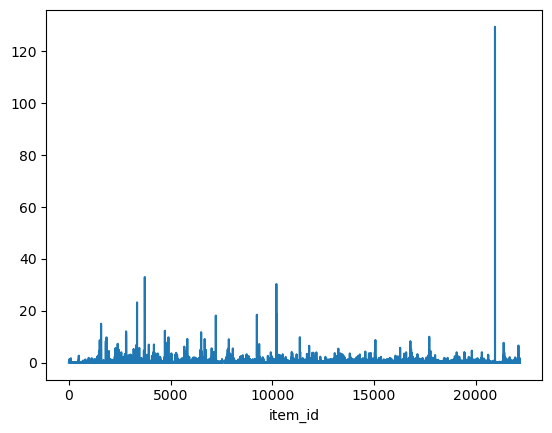

In [23]:
all_data.groupby('item_id')['target'].mean().plot()

In [24]:
# YOUR CODE GOES HERE
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=False)

for index_train, index_valid in kf.split(all_data):
    X_tr, X_val = all_data.iloc[index_train], all_data.iloc[index_valid]
    
    # target coding of valid dataset depends on train dataset
    X_tr_group = X_tr.groupby('item_id')['target'] 
    X_val['item_target_enc'] = X_val['item_id'].map(X_tr_group.mean())
    
    # copy target encoding back to all_data
    all_data.iloc[index_valid] = X_val
    

all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values
    

# You will need to compute correlation like that
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
print('KFold_scheme', corr)

/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/1705336231.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['item_target_enc'] = X_val['item_id'].map(X_tr_group.mean())
/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/1705336231.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['item_target_enc'] = X_val['item_id'].map(X_tr_group.mean())
/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/1705336231.py:11: SettingWithCopyWarning: 
A value is t

0.4164590712798752
KFold_scheme 0.4164590712798752


/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/1705336231.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['item_target_enc'] = X_val['item_id'].map(X_tr_group.mean())
/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/1705336231.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation

# 2. Leave-one-out scheme

Now, implement leave-one-out scheme. Note that if you just simply set the number of folds to the number of samples and run the code from the **KFold scheme**, you will probably wait for a very long time. 

To implement a faster version, note, that to calculate mean target value using all the objects but one *given object*, you can:

1. Calculate sum of the target values using all the objects.
2. Then subtract the target of the *given object* and divide the resulting value by `n_objects - 1`. 

Note that you do not need to perform `1.` for every object. And `2.` can be implemented without any `for` loop.

It is the most convenient to use `.transform` function as in **Method 2**.

In [25]:
%%time
# YOUR CODE GOES HERE

# Calculate sum of the target values using all the objects.
target_sum = all_data.groupby('item_id')['target'].transform('sum')

# Then subtract the target of the given object and divide the resulting value by n_objects - 1.
n_objects = all_data.groupby('item_id')['target'].transform('count')

all_data['item_target_enc'] = (target_sum - all_data['target']) / (n_objects - 1)
all_data['item_target_enc'].fillna(0.3343, inplace=True)
encoded_feature = all_data['item_target_enc'].values


corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
print('Leave-one-out_scheme', corr)
print()

0.4803848311292982
Leave-one-out_scheme 0.4803848311292982

CPU times: user 201 ms, sys: 91.6 ms, total: 292 ms
Wall time: 321 ms


<timed exec>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# 3. Smoothing

Explained starting at 4:03 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Next, implement smoothing scheme with $\alpha = 100$. Use the formula from the first slide in the video and $0.3343$ as `globalmean`. Note that `nrows` is the number of objects that belong to a certain category (not the number of rows in the dataset).

In [26]:
%%time

# YOUR CODE GOES HERE
alpha = 100

item_id_target_mean = all_data.groupby('item_id')['target'].transform('mean')
n_objects = all_data.groupby('item_id')['target'].transform('count')

all_data['item_target_enc'] = (item_id_target_mean * n_objects + 0.3343*alpha) / (n_objects + alpha)

all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values


corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
print('Smoothing_scheme', corr)
print()

0.48181987970972256
Smoothing_scheme 0.48181987970972256

CPU times: user 218 ms, sys: 101 ms, total: 319 ms
Wall time: 351 ms


<timed exec>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




# 4. Expanding mean scheme

Explained starting at 5:50 of [Regularization video](https://www.coursera.org/learn/competitive-data-science/lecture/LGYQ2/regularization).

Finally, implement the *expanding mean* scheme. It is basically already implemented for you in the video, but you can challenge yourself and try to implement it yourself. You will need [`cumsum`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.cumsum.html) and [`cumcount`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.GroupBy.cumcount.html) functions from pandas.

In [27]:
print('shape of cumulative sum: {:,}'.format(all_data.groupby('item_id')['target'].cumsum().shape[0]))

shape of cumulative sum: 10,913,850


In [28]:
# YOUR CODE GOES HERE
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id').cumcount()

all_data['item_target_enc'] = cumsum / cumcnt
all_data['item_target_enc'].fillna(0.3343, inplace=True) 
encoded_feature = all_data['item_target_enc'].values

corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)
print('Expanding_mean_scheme', corr)

0.5025245211081674
Expanding_mean_scheme 0.5025245211081674


/var/folders/bq/fnyq_s7j697_v7q04hfqmy_m0000gn/T/ipykernel_89266/3221858843.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['item_target_enc'].fillna(0.3343, inplace=True)


## Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. Note: Token expires 30 minutes after generation.

In [29]:
# STUDENT_EMAIL = 'brandon.hy.lin.0@gmail.com' # EMAIL HERE
# STUDENT_TOKEN = 'EC3Bgq6dNzp8q92S'  # TOKEN HERE
# grader.status()

In [30]:
# grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)